In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# pd.Series(np.repeat(['reana', 'reanaE'], [10+1,10+1], axis=0))
df_reanae = pd.read_csv('totalTimeBSN_ReanaE.csv', header=None).transpose()
df_reanae = df_reanae.drop([11])

In [16]:
# column i has data for evolution i
# each row is a separate execution
# df.columns = ["{}".format(i) for i in range(0, N_EVOLUTIONS+1)]

# df_reanae = pd.read_csv('totalTimeBSN_ReanaE.csv', header=None).transpose()
# df_reanae.set_axis(["Execution {}".format(i) for i in range(0, N_EXECUTIONS+1)], axis='index')

df_reana = pd.read_csv('totalTimeBSN_Reana.csv', header=None).transpose()
# df_reana.set_axis(["Execution {}".format(i) for i in range(0, N_EXECUTIONS+1)], axis='index')

df = pd.concat([df_reana, df_reanae], keys=['reana', 'reanae'])
# df /= 1000.0
# df['Type'] = pd.Series(np.repeat(['reana', 'reanaE'], [10+1,10+1], axis=0))
df['Type'] = np.repeat(['reana', 'reanaE'], [10+1,10+1], axis=0)
df

0       1      2      3      4      5      6      7       8  \
reana  0   1110.0   413.0  455.0  420.0  431.0  430.0  476.0  497.0   535.0   
       1   3200.0   577.0  690.0  561.0  619.0  475.0  647.0  475.0   542.0   
       2    934.0   410.0  500.0  429.0  487.0  473.0  504.0  609.0   491.0   
       3   2310.0   584.0  456.0  564.0  682.0  857.0  556.0  578.0   638.0   
       4   3178.0   866.0  668.0  601.0  607.0  606.0  535.0  971.0   481.0   
       5   4009.0  1075.0  726.0  627.0  702.0  848.0  722.0  496.0   765.0   
       6    737.0   400.0  435.0  410.0  413.0  437.0  480.0  471.0   481.0   
       7   3121.0   701.0  580.0  496.0  779.0  490.0  529.0  708.0   487.0   
       8   1976.0   506.0  864.0  604.0  456.0  479.0  475.0  490.0   535.0   
       9   2573.0   720.0  444.0  750.0  505.0  671.0  643.0  618.0  1015.0   
       10  6291.0   539.0  692.0  739.0  537.0  674.0  688.0  498.0   652.0   
reanae 0   1379.0   464.0  411.0  605.0  352.0  371.0  372.0  385.0   432.0   
       1    401.0   397.0  368.0  372.0  378.0  411.0  391.0  408.0   411.0   
       2   4676.0   492.0  500.0  404.0  394.0  463.0  388.0  399.0   463.0   
       3   3396.0   501.0  496.0  400.0  417.0  446.0  433.0  399.0   458.0   
       4    836.0   371.0  372.0  434.0  364.0  446.0  429.0  490.0   488.0   
       5   3055.0   563.0  409.0  548.0  423.0  557.0  450.0  508.0   515.0   
       6    736.0   387.0  357.0  350.0  368.0  362.0  385.0  402.0   462.0   
       7   2087.0   638.0  417.0  481.0  372.0  461.0  449.0  420.0   519.0   
       8   4392.0   569.0  432.0  462.0  548.0  474.0  376.0  424.0   463.0   
       9    821.0   456.0  355.0  377.0  370.0  405.0  423.0  399.0   425.0   
       10  1067.0   407.0  389.0  373.0  461.0  384.0  407.0  453.0   558.0   

                9  ...      12      13      14      15       16       17  \
reana  0    558.0  ...  2461.0  2291.0  4418.0  8717.0  18237.0  39222.0   
       1    584.0  ...  2524.0  2280.0  4528.0  8814.0  17831.0  39442.0   
       2    563.0  ...  2364.0  2272.0  4370.0  8604.0  17772.0  40082.0   
       3    577.0  ...  2518.0  2379.0  4366.0  8670.0  17577.0  40192.0   
       4    645.0  ...  2420.0  2281.0  4379.0  8799.0  18187.0  39168.0   
       5   1061.0  ...  2394.0  2258.0  4435.0  8472.0  17387.0  39137.0   
       6    513.0  ...  2435.0  2305.0  4497.0  8742.0  17879.0  40017.0   
       7    523.0  ...  2403.0  2308.0  4765.0  8687.0  17701.0  38000.0   
       8    540.0  ...  2386.0  2320.0  4295.0  8792.0  18384.0  39967.0   
       9    612.0  ...  2673.0  2275.0  4523.0  8865.0  17701.0  39049.0   
       10   571.0  ...  2497.0  2305.0  4515.0  8581.0  18394.0  38238.0   
reanae 0    473.0  ...  1311.0  2250.0  4404.0  8872.0  17587.0  38296.0   
       1    544.0  ...  1275.0  2268.0  4576.0  9112.0  17888.0  38012.0   
       2    534.0  ...  1313.0  2254.0  4815.0  8985.0  18271.0  38431.0   
       3    484.0  ...  1345.0  2321.0  4477.0  8819.0  17949.0  38900.0   
       4    755.0  ...  1351.0  2246.0  4395.0  8822.0  17907.0  39603.0   
       5    582.0  ...  1385.0  2337.0  4479.0  8983.0  18065.0  37356.0   
       6    481.0  ...  1248.0  2275.0  4400.0  8743.0  17962.0  39087.0   
       7    474.0  ...  1250.0  2255.0  4527.0  8935.0  18172.0  38718.0   
       8    471.0  ...  1340.0  2281.0  4453.0  9014.0  18565.0  39360.0   
       9    548.0  ...  1261.0  2256.0  4488.0  8729.0  17985.0  38656.0   
       10   544.0  ...  1261.0  2251.0  4428.0  8796.0  17892.0  39741.0   

                 18        19        20    Type  
reana  0   120085.0  425823.0  892820.0   reana  
       1   118258.0  421734.0  850745.0   reana  
       2   119943.0  420526.0  878276.0   reana  
       3   116758.0  411620.0  877227.0   reana  
       4   119649.0  414876.0  876456.0   reana  
       5   121215.0  412099.0  866763.0   reana  
       6   113909.0  423135.0  858800.0   reana  
       7   114644.0  421929.0  860945.0   reana  

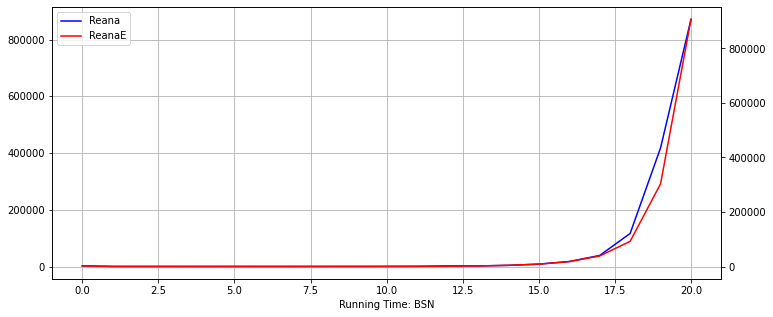

In [33]:
reana_mean = np.mean(df.loc['reana'])
reanae_mean = np.mean(df.loc['reanae'])
# df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))
df_mean = pd.concat([reana_mean, reanae_mean], keys=['reana', 'reanae'])

plt.figure(figsize=(12,5))
plt.xlabel('Running Time: BSN')

ax1 = df_mean['reana'].plot(color='blue', grid=True, label='Reana')
ax2 = df_mean['reanae'].plot(color='red', grid=True, secondary_y=True, label='ReanaE')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Running Time: BSN')

ax1 = df.A.plot(color='blue', grid=True, label='Count')
ax2 = df.B.plot(color='red', grid=True, secondary_y=True, label='Sum')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:364: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


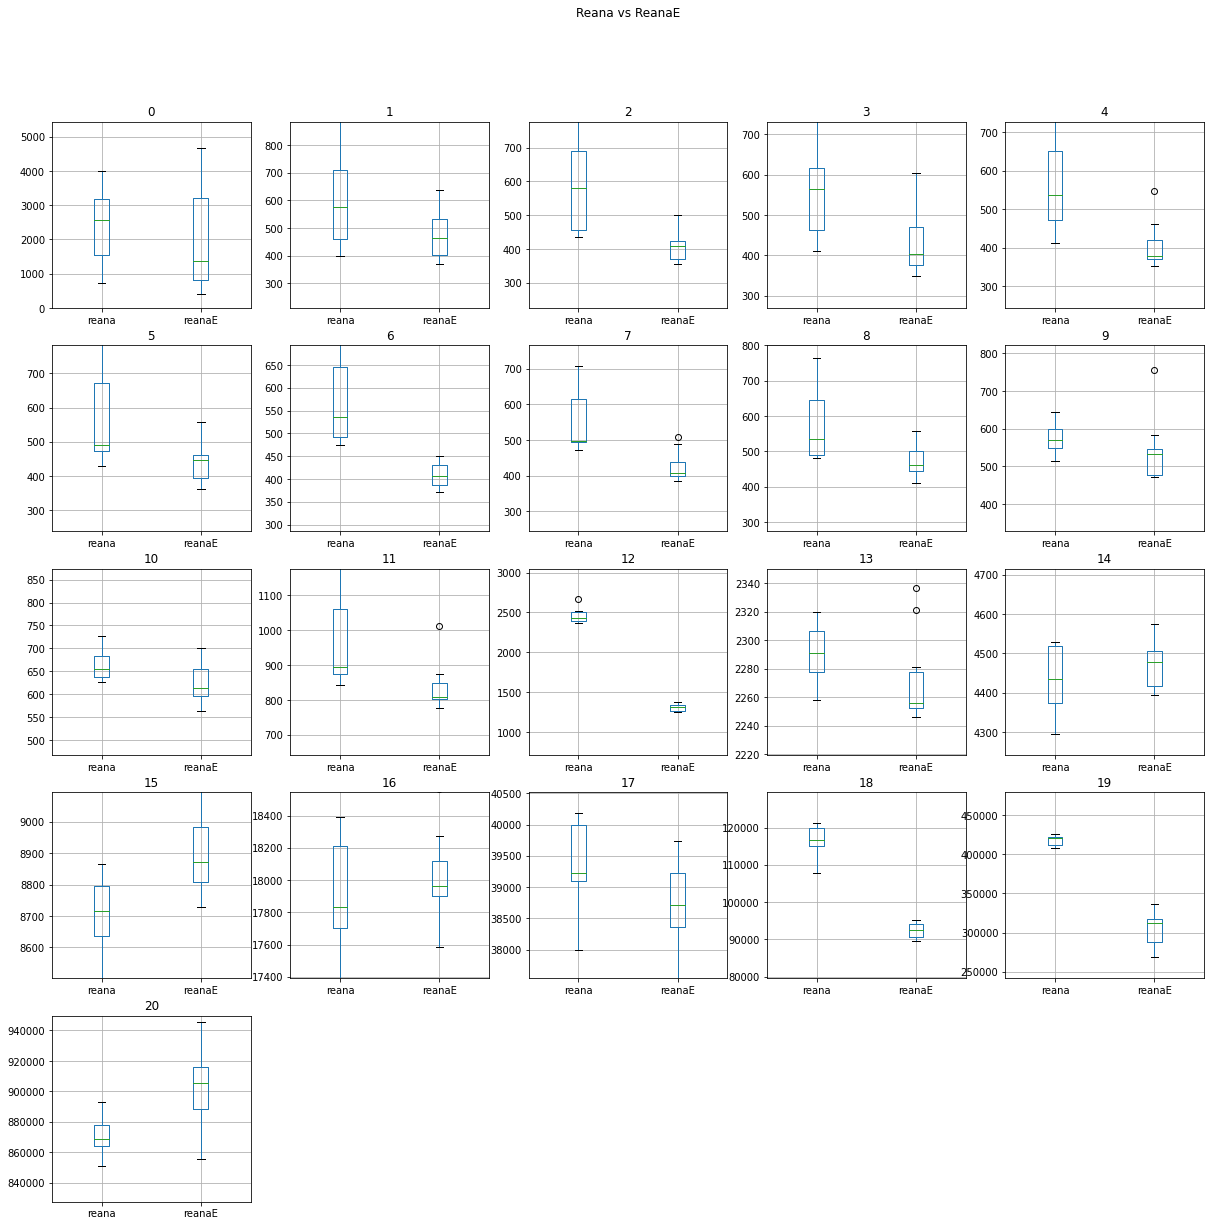

In [20]:
# df = np.log10(df)

# fig, ax1 = plt.subplots()
# df.loc['reana'].boxplot(figsize=(14,14))

# ax2 = ax1.twinx()
# df.loc['reanae'].boxplot()

# plt.show()
# plt.figure();
# axes = df.boxplot(by='Type', figsize=(20,20), return_type='axes')
# print(axes)
means = np.mean(df)
stdevs = np.std(df)

fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
fig.delaxes(ax_new[4,1])
fig.delaxes(ax_new[4,2])
fig.delaxes(ax_new[4,3])
fig.delaxes(ax_new[4,4])
bp = df.boxplot(by="Type",ax=ax_new.flatten()[:21], figsize=(6,8))
# [ax_tmp.set_xlabel('Type') for ax_tmp in ax_new.reshape(-1)]

for i in range(21):
# for i in range(1):
    mean = means[i]
    stdev = stdevs[i]
    ax_new.flatten()[i].set_ylim(max(0, mean-2*stdev),mean+2*stdev)
    ax_new.flatten()[i].set_xlabel('')
    
fig.suptitle('Reana vs ReanaE')
plt.show()

In [279]:
len(ax_new.flatten())

25

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


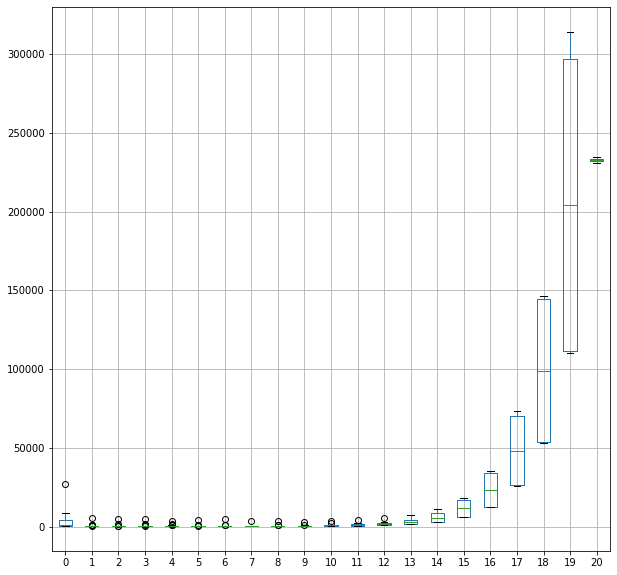

In [114]:
boxplot = df.boxplot(figsize=(10,10))
boxplot

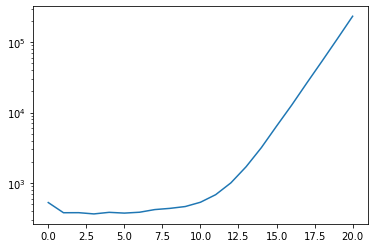

In [101]:
ts.plot(logy=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4475818e0>,
      dtype=object)

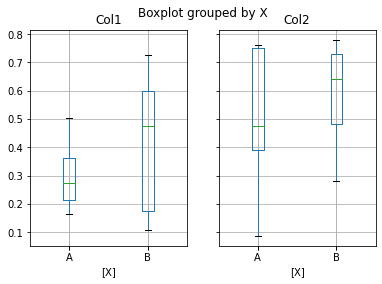

In [159]:
dft = pd.DataFrame(np.random.rand(10, 2), columns=['Col1', 'Col2'])
dft['X'] = pd.Series(['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B'])
dft.boxplot(by='X')